# Machine Learning Engineer Nanodegree - Capstone Project
## PART 7: Model Evaluation

**Author:** Giacomo Sarchioni

In [2]:
# Module imports
import pickle as pkl
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from roc_chart import ROCChart
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from roc_chart import ROCChart
from sklearn.externals import joblib
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from scipy.stats import ttest_rel

random_seed = 42

## Import data

In [3]:
# Load reviews
with open('reviews/sentiment_reviews/sentiment.pkl', 'rb') as f:
    sentiment_reviews = pkl.load(f)
    
# Load indexes
with open('split_indexes/indexes.pkl', 'rb') as f:
    indexes = pkl.load(f)

In [4]:
# Extract scores
scores = sentiment_reviews.adj_score.values

# Extract non-test and test scores
non_test_scores = scores[indexes['non_test']]
test_scores = scores[indexes['test']]

# Extract train and validation scores
train_scores = non_test_scores[indexes['train']]
val_scores = non_test_scores[indexes['val']]

# Transform scores into categorical
scores_cat = keras.utils.to_categorical(scores,2)

# Extract non-test and test scores
non_test_scores_cat = scores_cat[indexes['non_test']]
test_scores_cat = scores_cat[indexes['test']]

# Extract train and validation scores
train_scores_cat = non_test_scores_cat[indexes['train']]
val_scores_cat = non_test_scores_cat[indexes['val']]

In [5]:
# Extract parser_zero_reviews 
parser_zero_reviews = sentiment_reviews.loc[:,'parser_zero'].values

# Extract non test parser two reviews and scores
non_test_parser_zero_reviews = parser_zero_reviews[indexes['non_test']]
test_parser_zero_reviews = parser_zero_reviews[indexes['test']]

# Extract train and validation parser-two reviews
train_parser_zero_reviews = non_test_parser_zero_reviews[indexes['train']]
val_parser_zero_reviews = non_test_parser_zero_reviews[indexes['val']]

In [6]:
# Extract parser_one_reviews 
parser_one_reviews = sentiment_reviews.loc[:,'parser_one'].values

# Extract non test parser two reviews and scores
non_test_parser_one_reviews = parser_one_reviews[indexes['non_test']]
test_parser_one_reviews = parser_one_reviews[indexes['test']]

# Extract train and validation parser-two reviews
train_parser_one_reviews = non_test_parser_one_reviews[indexes['train']]
val_parser_one_reviews = non_test_parser_one_reviews[indexes['val']]

## Import log reg benchmark model

In [6]:
# Load log reg benchmark
bmk_log_reg = joblib.load('bmk_models/bmk_log_reg.pkl')

## Parse data for deep learning models

In [8]:
# Define number words in tokenizer
n_words_tokenizer = None

# Define max_len for reviews
max_len = 50

In [9]:
# Tokenise and pad  parser_zero reviews
# Import tokeniser
keras_tokenizer = Tokenizer(num_words = n_words_tokenizer)

keras_tokenizer.fit_on_texts(train_parser_one_reviews)

# Tokenise train, val and test parser_zero reviews
tokenised_train = keras_tokenizer.texts_to_sequences(train_parser_one_reviews)
tokenised_val = keras_tokenizer.texts_to_sequences(val_parser_one_reviews)
tokenised_test = keras_tokenizer.texts_to_sequences(test_parser_one_reviews)

# Transform reviews into sequences using pad_sequences
padded_train = pad_sequences(tokenised_train, maxlen=max_len, padding='post')
padded_val = pad_sequences(tokenised_val, maxlen=max_len, padding='post')
padded_test = pad_sequences(tokenised_test, maxlen=max_len, padding='post')

## Import deep learning model

In [10]:
deep_learning_model = load_model('final_model/dl_final.hdf5')

## Predictions

#### Validation

In [11]:
# Bmk prediciton on validation set
val_bmk_pred = bmk_log_reg.predict(val_parser_one_reviews)

# Deep Learning prediction on validation set
val_dl_pred = deep_learning_model.predict_classes(padded_val)

AUC score for Bmk Log Reg is 0.8609
AUC score for Refined Model is 0.8832


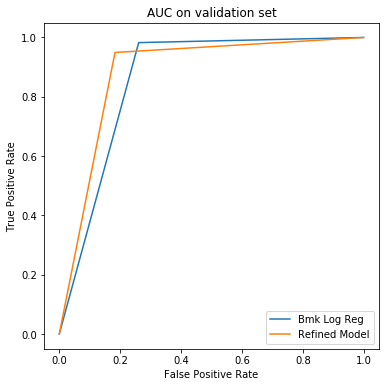

In [12]:
# Print comparison chart
comparison_chart = ROCChart(val_scores,
                            [val_bmk_pred, val_dl_pred],
                            ['Bmk Log Reg', 'Refined Model'],
                            'AUC on validation set')
comparison_chart.plot()

#### Test

In [13]:
# Bmk prediciton on test set
test_bmk_pred = bmk_log_reg.predict(test_parser_one_reviews)

# Deep Learning prediction on test set
test_dl_pred = deep_learning_model.predict_classes(padded_test)

AUC score for Bmk Log Reg is 0.8590
AUC score for Refined Model is 0.8810


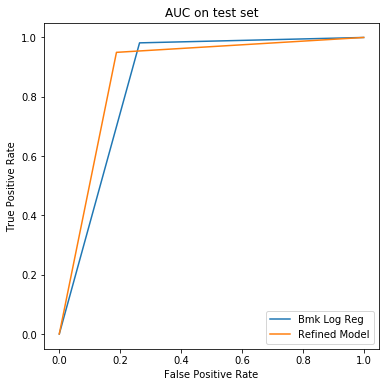

In [14]:
# Print comparison chart
comparison_chart = ROCChart(test_scores,
                            [test_bmk_pred, test_dl_pred],
                            ['Bmk Log Reg', 'Refined Model'],
                            'AUC on test set')
comparison_chart.plot()

## Build Deep Learning classifier

In [15]:
# Dump keras tokeniser
with open('final_model/dl_tokeniser.pkl', 'wb') as f:
    pkl.dump(keras_tokenizer, f)

In [3]:
import pickle as pkl
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

class DL_Classifier:
    
    def __init__(self, tokeniser_path, model_path, num_words=50):
        
        with open(tokeniser_path, 'rb') as f:
            self.tokeniser = pkl.load(f)
             
        self.model = load_model(model_path)
        self.num_words = num_words
        
    def predict(self, reviews, return_proba=False):
        
        reviews = self.tokeniser.texts_to_sequences(reviews)
        reviews = pad_sequences(reviews, self.num_words, padding='post')
        
        predictions = self.model.predict(reviews)
        
        if return_proba:
            return predictions
        else:
            return predictions.argmax(axis=1)

In [4]:
DL_model = DL_Classifier('final_model/dl_tokeniser.pkl', 'final_model/dl_final.hdf5')

In [5]:
DL_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           32005200  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            48032     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50, 32)            0         
_________________________________________________________________
average_pooling1d_1 (Average (None, 25, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 64)            6208      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 25, 64)            0         
_________________________________________________________________
average_pooling1d_2 (Average (None, 13, 64)            0         
__________

## Prediction on some reviews

#### Order of words

In [7]:
test = ["I bought this product and I found it not to be very good"]

In [8]:
bmk_log_reg.predict_proba(test)

array([[ 0.07372849,  0.92627151]])

In [9]:
DL_model.predict(test, return_proba=True)

array([[ 0.8618325 ,  0.13816744]], dtype=float32)

#### 10 Test Reviews

In [21]:
comparison_reviews = test_parser_zero_reviews[:10]
comparison_parser_one = test_parser_one_reviews[:10]
comparison_bmk_pred = [int(x) for x in bmk_log_reg.predict(comparison_parser_one)]
comparison_dl_pred = DL_model.predict(comparison_parser_one, False)

In [25]:
results = pd.DataFrame({'text' : comparison_reviews, 
                        'bmk_pred' : comparison_bmk_pred, 
                        'dl_pred' : comparison_dl_pred, 
                        'true' : [int(x) for x in test_scores[:10]]})

In [26]:
results

,bmk_pred,dl_pred,text,true
0,1,1,bought this 1 lb merckens coco lite coatings t...,1
1,0,0,i didn't like this. i couldn't finish the enti...,0
2,1,1,i bought a package of these in amish country a...,1
3,1,1,"i love this coffee, but i am having trouble fi...",1
4,1,1,the product was shipped fast and packaged in a...,1
5,1,1,nothing better than these pancakes with some c...,1
6,1,0,i purchased these candy bars and yes they are ...,0
7,1,1,"this is really, really great tea. it's rich an...",1
8,0,1,"this gum's flavor is more akin to orange, or b...",1
9,1,1,i have been buying this product since i discov...,1


## Statistical test

In [32]:
# Extract sample of 100 test reviews and calculate AUC score using the benchmark model and the deep learning model
sample_size = 100
n_samples = len(test_parser_one_reviews)//sample_size
print("AUC score for both models will be calculated on {} samples.".format(n_samples))

AUC score for both models will be calculated on 363 samples.


In [55]:
bmk_auc_samples = []
dl_auc_samples = []
for i in range(n_samples):
    sample_reviews = test_parser_one_reviews[i*sample_size:i*sample_size+sample_size]
    sample_scores = test_scores[i*sample_size:i*sample_size+sample_size]
    
    # Prediction for benchmark model
    bmk_pred = bmk_log_reg.predict(sample_reviews)
    
    # Prediction for deep learning model
    dl_pred = DL_model.predict(sample_reviews)
    
    # Calculate auc score for benchmark model
    bmk_auc = roc_auc_score(sample_scores, bmk_pred)
    
    # Calculate auc score for deep learning model
    dl_auc = roc_auc_score(sample_scores, dl_pred)
    
    # Append auc scores
    bmk_auc_samples.append(bmk_auc)
    dl_auc_samples.append(dl_auc)

#### t-test

In [58]:
ttest_rel(bmk_auc_samples, dl_auc_samples)

Ttest_relResult(statistic=-7.008825298937462, pvalue=1.1816195225222823e-11)